# GAMMA Challenge Subtask 1 Glaucoma Grading - Marco

- Unzip files in first time runs.

In [ ]:
# !cp data/data?????/training_data.zip ./
# !cp data/data?????/validation_data.zip ./
# !unzip training_data.zip > /dev/null
# !unzip validation_data.zip > /dev/null

In [ ]:
!pwd

/home/aistudio


In [ ]:
!unzip -o /home/aistudio/data/data100624/GAMMA_training_data.zip  -d /home/aistudio/

In [ ]:
!rm */.DS_Store
!rm */*/.DS_Store
!rm */*/*/.DS_Store

- Import packages

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.vision.models import resnet34, resnet50

import transforms as trans

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Config

In [ ]:
batchsize = 4 # 4 patients per iter, i.e, 20 steps / epoch
oct_img_size = [512, 512]
image_size = 256
iters = 1000 # For demonstration purposes only, far from reaching convergence
val_ratio = 0.2 # 80 / 20
trainset_root = "training_data/multi-modality_images"
# test_root = ""
num_workers = 4
init_lr = 1e-4
optimizer_type = "adam"

# Train / Val splitition

In [ ]:
filelists = os.listdir(trainset_root)
train_filelists, val_filelists = train_test_split(filelists, test_size=val_ratio, random_state=12)
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))
print(val_filelists)

Total Nums: 100, train: 80, val: 20
['0029', '0005', '0045', '0090', '0075', '0007', '0058', '0055', '0071', '0001', '0054', '0008', '0006', '0043', '0017', '0076', '0026', '0060', '0019', '0022']


# DataLoader

- GAMMA_sub1_dataset:
	
    Load oct images and fundus images according to `patient id`
        

In [ ]:
class GAMMA_sub1_dataset(paddle.io.Dataset):
    """
    getitem() output:
    
    	fundus_img: RGB uint8 image with shape (3, image_size, image_size)
        
        oct_img:    Uint8 image with shape (256, oct_img_size[0], oct_img_size[1])
    """

    def __init__(self,
                 img_transforms,
                 oct_transforms,
                 dataset_root,
                 label_file='',
                 filelists=None,
                 num_classes=3,
                 mode='train'):

        self.dataset_root = dataset_root
        self.img_transforms = img_transforms
        self.oct_transforms = oct_transforms
        self.mode = mode.lower()
        self.num_classes = num_classes
        
        if self.mode == 'train':
            label = {row['data']: row[1:].values 
                        for _, row in pd.read_excel(label_file).iterrows()}

            self.file_list = [[f, label[int(f)]] for f in os.listdir(dataset_root)]
        elif self.mode == "test":
            self.file_list = [[f, None] for f in os.listdir(dataset_root)]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists]

    def __getitem__(self, idx):
        real_index, label = self.file_list[idx]

        fundus_img_path = os.path.join(self.dataset_root, real_index, real_index + ".jpg")
        oct_series_list = sorted(os.listdir(os.path.join(self.dataset_root, real_index, real_index)), 
                                    key=lambda x: int(x.strip("_")[0]))

        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] # BGR -> RGB
        oct_series_0 = cv2.imread(os.path.join(self.dataset_root, real_index, real_index, oct_series_list[0]), 
                                    cv2.IMREAD_GRAYSCALE)
        oct_img = np.zeros((len(oct_series_list), oct_series_0.shape[0], oct_series_0.shape[1], 1), dtype="uint8")

        for k, p in enumerate(oct_series_list):
            oct_img[k] = cv2.imread(
                os.path.join(self.dataset_root, real_index, real_index, p), cv2.IMREAD_GRAYSCALE)[..., np.newaxis]

        if self.img_transforms is not None:
            fundus_img = self.img_transforms(fundus_img)
        if self.oct_transforms is not None:
            oct_img = self.oct_transforms(oct_img)
 
        # normlize on GPU to save CPU Memory and IO consuming.
        # fundus_img = (fundus_img / 255.).astype("float32")
        # oct_img = (oct_img / 255.).astype("float32")

        fundus_img = fundus_img.transpose(2, 0, 1) # H, W, C -> C, H, W
        oct_img = oct_img.squeeze(-1) # D, H, W, 1 -> D, H, W

        if self.mode == 'test':
            return fundus_img, oct_img, real_index
        if self.mode == "train":
            label = label.argmax()
            return fundus_img, oct_img, label

    def __len__(self):
        return len(self.file_list)

In [ ]:
img_train_transforms = trans.Compose([
    trans.RandomResizedCrop(
        image_size, scale=(0.90, 1.1), ratio=(0.90, 1.1)),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip(),
    trans.RandomRotation(30)
])

oct_train_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip()
])

img_val_transforms = trans.Compose([
    trans.CropCenterSquare(),
    trans.Resize((image_size, image_size))
])

oct_val_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

In [ ]:
_train = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_train_transforms,
                        oct_transforms=oct_train_transforms,
                        label_file='training_data/glaucoma_grading_training_GT.xlsx')

_val = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_val_transforms,
                        oct_transforms=oct_val_transforms,
                        label_file='training_data/glaucoma_grading_training_GT.xlsx')

- Visualzation and check dataloader 

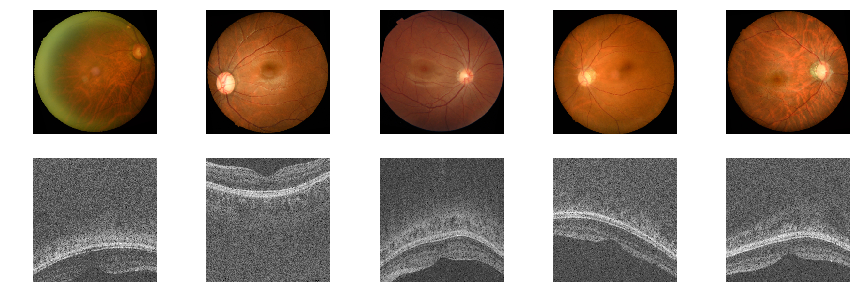

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = _train.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

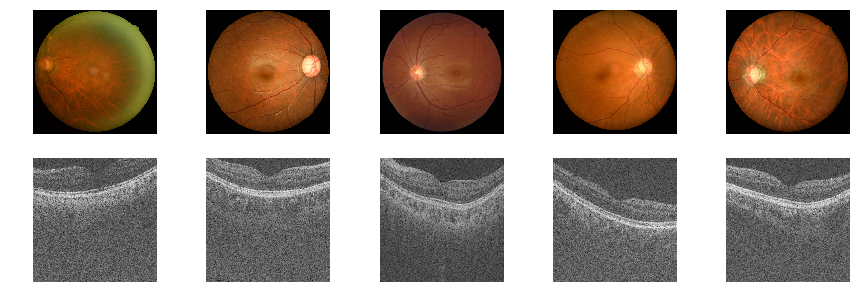

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = _val.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

# Network

In [ ]:
class Model(nn.Layer):
    """
    simply create a 2-branch network, and concat global pooled feature vector.
    each branch = single resnet34
    """
    def __init__(self):
        super(Model, self).__init__()
        self.fundus_branch = resnet34(pretrained=True, num_classes=0) # remove final fc
        self.oct_branch = resnet34(pretrained=True, num_classes=0) # remove final fc
        self.decision_branch = nn.Linear(512 * 1 * 2, 3) # ResNet34 use basic block, expansion = 1
        
        # replace first conv layer in oct_branch
        self.oct_branch.conv1 = nn.Conv2D(256, 64,
                                        kernel_size=7,
                                        stride=2,
                                        padding=3,
                                        bias_attr=False)

    def forward(self, fundus_img, oct_img):
        b1 = self.fundus_branch(fundus_img)
        b2 = self.oct_branch(oct_img)
        b1 = paddle.flatten(b1, 1)
        b2 = paddle.flatten(b2, 1)
        logit = self.decision_branch(paddle.concat([b1, b2], 1))

        return logit

In [ ]:
class Model_resnet50(nn.Layer):
    """
    simply create a 2-branch network, and concat global pooled feature vector.
    each branch = single resnet34
    """
    def __init__(self):
        super(Model_resnet50, self).__init__()
        self.fundus_branch = resnet50(pretrained=True, num_classes=0) # remove final fc
        self.oct_branch = resnet50(pretrained=True, num_classes=0) # remove final fc
        self.decision_branch = nn.Linear(512 * 4 * 2, 3) # ResNet34 use bottleneck block, expansion = 4
        
        # replace first conv layer in oct_branch
        self.oct_branch.conv1 = nn.Conv2D(256, 64,
                                        kernel_size=7,
                                        stride=2,
                                        padding=3,
                                        bias_attr=False)

    def forward(self, fundus_img, oct_img):
        b1 = self.fundus_branch(fundus_img)
        b2 = self.oct_branch(oct_img)
        b1 = paddle.flatten(b1, 1)
        b2 = paddle.flatten(b2, 1)
        logit = self.decision_branch(paddle.concat([b1, b2], 1))

        return logit

# Utils

In [ ]:
def train(model, iters, train_dataloader, val_dataloader, optimizer, criterion, log_interval, eval_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_kappa_list = []
    best_kappa = 0.
    while iter < iters:
        for data in train_dataloader:
            iter += 1
            if iter > iters:
                break
            fundus_imgs = (data[0] / 255.).astype("float32")
            oct_imgs = (data[1] / 255.).astype("float32")
            labels = data[2].astype('int64')

            logits = model(fundus_imgs, oct_imgs)
            loss = criterion(logits, labels)
            # acc = paddle.metric.accuracy(input=logits, label=labels.reshape((-1, 1)), k=1)
            for p, l in zip(logits.numpy().argmax(1), labels.numpy()):
                avg_kappa_list.append([p, l])

            loss.backward()
            optimizer.step()

            model.clear_gradients()
            avg_loss_list.append(loss.numpy()[0])

            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                avg_kappa_list = np.array(avg_kappa_list)
                avg_kappa = cohen_kappa_score(avg_kappa_list[:, 0], avg_kappa_list[:, 1], weights='quadratic')
                avg_loss_list = []
                avg_kappa_list = []
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_kappa={:.4f}".format(iter, iters, avg_loss, avg_kappa))

            if iter % eval_interval == 0:
                avg_loss, avg_kappa = val(model, val_dataloader, criterion)
                print("[EVAL] iter={}/{} avg_loss={:.4f} kappa={:.4f}".format(iter, iters, avg_loss, avg_kappa))
                if avg_kappa >= best_kappa:
                    best_kappa = avg_kappa
                    paddle.save(model.state_dict(),
                            os.path.join('trained_models', "best_model_{:.4f}".format(best_kappa), 'model.pdparams'))
                    paddle.save(optimizer.state_dict(), 
                            os.path.join('trained_models',"best_model_{:.4f}".format(best_kappa), 'optimizer.pdopt'))
                model.train()

def val(model, val_dataloader, criterion):
    model.eval()
    avg_loss_list = []
    cache = []
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_imgs = (data[0] / 255.).astype("float32")
            oct_imgs = (data[1] / 255.).astype("float32")
            labels = data[2].astype('int64')
            
            logits = model(fundus_imgs, oct_imgs)
            for p, l in zip(logits.numpy().argmax(1), labels.numpy()):
                cache.append([p, l])

            loss = criterion(logits, labels)
            # acc = paddle.metric.accuracy(input=logits, label=labels.reshape((-1, 1)), k=1)
            avg_loss_list.append(loss.numpy()[0])
    cache = np.array(cache)
    kappa = cohen_kappa_score(cache[:, 0], cache[:, 1], weights='quadratic')
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, kappa

# Training

In [ ]:
img_train_transforms = trans.Compose([
    trans.RandomResizedCrop(
        image_size, scale=(0.90, 1.1), ratio=(0.90, 1.1)),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip(),
    trans.RandomRotation(30)
])

oct_train_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip()
])

img_val_transforms = trans.Compose([
    trans.CropCenterSquare(),
    trans.Resize((image_size, image_size))
])

oct_val_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

train_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_train_transforms,
                        oct_transforms=oct_train_transforms,
                        filelists=train_filelists,
                        label_file='training_data/glaucoma_grading_training_GT.xlsx')

val_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_val_transforms,
                        oct_transforms=oct_val_transforms,
                        filelists=val_filelists,
                        label_file='training_data/glaucoma_grading_training_GT.xlsx')

In [ ]:
train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

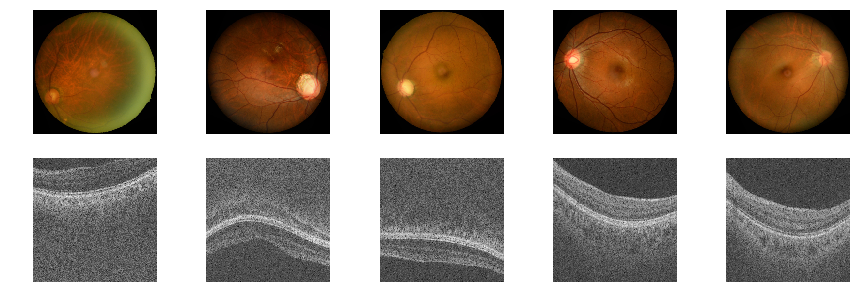

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = train_dataset.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

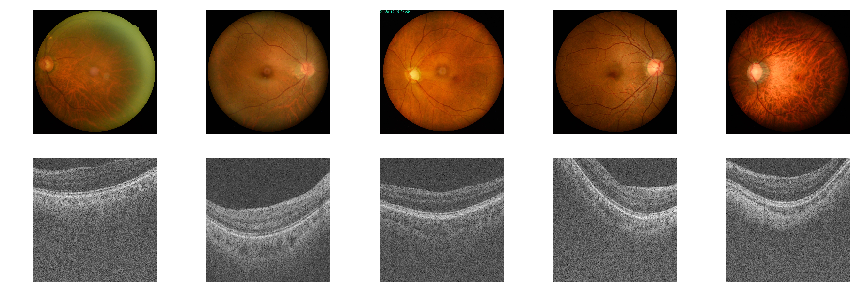

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = val_dataset.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

In [ ]:
model = Model()

if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())

criterion = nn.CrossEntropyLoss()

2021-08-01 22:44:10,818 - INFO - unique_endpoints {''}
2021-08-01 22:44:10,820 - INFO - Downloading resnet34.pdparams from https://paddle-hapi.bj.bcebos.com/models/resnet34.pdparams
100%|██████████| 128669/128669 [00:02<00:00, 58192.90it/s]
2021-08-01 22:44:13,204 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-08-01 22:44:14,271 - INFO - unique_endpoints {''}
2021-08-01 22:44:14,272 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-08-01 22:44:14,561 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams


In [ ]:
train(model, iters, train_loader, val_loader, optimizer, criterion, log_interval=10, eval_interval=100)

[TRAIN] iter=10/1000 avg_loss=1.1618 avg_kappa=0.5230
[TRAIN] iter=20/1000 avg_loss=0.9554 avg_kappa=0.6642
[TRAIN] iter=30/1000 avg_loss=0.7104 avg_kappa=0.6825
[TRAIN] iter=40/1000 avg_loss=0.9156 avg_kappa=0.2844
[TRAIN] iter=50/1000 avg_loss=0.3947 avg_kappa=0.8033
[TRAIN] iter=60/1000 avg_loss=1.2611 avg_kappa=0.4510
[TRAIN] iter=70/1000 avg_loss=0.7921 avg_kappa=0.7278
[TRAIN] iter=80/1000 avg_loss=0.4554 avg_kappa=0.8846
[TRAIN] iter=90/1000 avg_loss=0.7364 avg_kappa=0.7143
[TRAIN] iter=100/1000 avg_loss=0.6309 avg_kappa=0.6941
[EVAL] iter=100/1000 avg_loss=1.2616 kappa=0.7895
[TRAIN] iter=110/1000 avg_loss=0.4823 avg_kappa=0.6307
[TRAIN] iter=120/1000 avg_loss=0.6336 avg_kappa=0.6957
[TRAIN] iter=130/1000 avg_loss=0.3856 avg_kappa=0.9083
[TRAIN] iter=140/1000 avg_loss=0.5934 avg_kappa=0.7936
[TRAIN] iter=150/1000 avg_loss=0.3020 avg_kappa=0.6644
[TRAIN] iter=160/1000 avg_loss=0.7636 avg_kappa=0.8207
[TRAIN] iter=170/1000 avg_loss=0.1419 avg_kappa=0.8891
[TRAIN] iter=180/1000 av

# Incremental Training

In [49]:
model= Model() # 

optimizer_type = 'sgd'
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(1e-4, parameters=model.parameters())
elif optimizer_type == 'sgd':
    optimizer = paddle.optimizer.SGD(learning_rate=1e-4, parameters=model.parameters(), 
                                     weight_decay=None) # , grad_clip=None, name=None
else:
    print("No such optimzier, please add it by yourself")
    

criterion = nn.CrossEntropyLoss()

para_state_dict = paddle.load("trained_models/best_model_0.9398/model.pdparams")
# opt_state_dict = paddle.load("trained_models/best_model_0.9276/optimizer.pdopt")

model.set_state_dict(para_state_dict)
# optimizer.set_state_dict(opt_state_dict)

train(model, iters, train_loader, val_loader, optimizer, criterion, log_interval=10, eval_interval=100)

2021-09-05 23:32:54,019 - INFO - unique_endpoints {''}
2021-09-05 23:32:54,020 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-09-05 23:32:54,392 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams
2021-09-05 23:32:55,231 - INFO - unique_endpoints {''}
2021-09-05 23:32:55,232 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-09-05 23:32:55,593 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams


[TRAIN] iter=10/1000 avg_loss=0.3108 avg_kappa=0.9422
[TRAIN] iter=20/1000 avg_loss=0.1836 avg_kappa=0.9280
[TRAIN] iter=30/1000 avg_loss=0.8440 avg_kappa=0.8357
[TRAIN] iter=40/1000 avg_loss=0.0852 avg_kappa=0.9772
[TRAIN] iter=50/1000 avg_loss=0.3432 avg_kappa=0.8843
[TRAIN] iter=60/1000 avg_loss=0.3500 avg_kappa=0.8554
[TRAIN] iter=70/1000 avg_loss=0.4236 avg_kappa=0.8390
[TRAIN] iter=80/1000 avg_loss=0.2798 avg_kappa=0.8276
[TRAIN] iter=90/1000 avg_loss=0.3489 avg_kappa=0.9554
[TRAIN] iter=100/1000 avg_loss=0.3565 avg_kappa=0.9312
[EVAL] iter=100/1000 avg_loss=0.0514 kappa=1.0000
[TRAIN] iter=110/1000 avg_loss=0.5635 avg_kappa=0.8750
[TRAIN] iter=120/1000 avg_loss=0.1784 avg_kappa=0.8982
[TRAIN] iter=130/1000 avg_loss=0.5472 avg_kappa=0.8868
[TRAIN] iter=140/1000 avg_loss=0.1431 avg_kappa=0.9608
[TRAIN] iter=150/1000 avg_loss=0.2415 avg_kappa=0.9429
[TRAIN] iter=160/1000 avg_loss=0.1982 avg_kappa=0.9436
[TRAIN] iter=170/1000 avg_loss=0.5318 avg_kappa=0.8182
[TRAIN] iter=180/1000 av

KeyboardInterrupt: 

# Experimental Records  
1st Training resnet34 0.8162 (700 iters)  
1st Incremental Training 0.9398 (300 iters)  


# Inference

In [ ]:
!unzip -o /home/aistudio/data/data103109/val_data.zip  -d /home/aistudio/val_data

In [51]:
best_model_path = "trained_models/best_model_1.0000/model.pdparams"
model = Model()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

testset_root = 'val_data/multi-modality_images' 

img_test_transforms = trans.Compose([
    trans.CropCenterSquare(),
    trans.Resize((image_size, image_size))
])

oct_test_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

test_dataset = GAMMA_sub1_dataset(dataset_root=testset_root, 
                        img_transforms=img_test_transforms,
                        oct_transforms=oct_test_transforms,
                        mode='test')

2021-09-05 23:44:20,263 - INFO - unique_endpoints {''}
2021-09-05 23:44:20,265 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-09-05 23:44:20,633 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams
2021-09-05 23:44:21,464 - INFO - unique_endpoints {''}
2021-09-05 23:44:21,465 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-09-05 23:44:21,829 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams


In [52]:
cache = []
for fundus_img, oct_img, idx in test_dataset:
    fundus_img = fundus_img[np.newaxis, ...]
    oct_img = oct_img[np.newaxis, ...]

    fundus_img = paddle.to_tensor((fundus_img / 255.).astype("float32"))
    oct_img = paddle.to_tensor((oct_img / 255.).astype("float32"))

    logits = model(fundus_img, oct_img)
    cache.append([idx, logits.numpy().argmax(1)])

In [54]:
submission_result = pd.DataFrame(cache, columns=['data', 'dense_pred'])

submission_result['non'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 0))
submission_result['early'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 1))
submission_result['mid_advanced'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 2))

submission_result[['data', 'non', 'early', 'mid_advanced']].to_csv("./Classification_Results.csv", index=False)